In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
image = "/content/drive/MyDrive/black-white-to-color/input/bba2c14s-960.jpg"

Загрузка сериализованной модели черно-белого колоризатора и кластера:

In [ ]:
prototxt = "/content/drive/MyDrive/black-white-to-color/colorization_models/colorization_deploy_v2.prototxt"
caffe_model = "/content/drive/MyDrive/black-white-to-color/colorization_models/colorization_release_v2.caffemodel"
pts_npy = "/content/drive/MyDrive/black-white-to-color/colorization_models/pts_in_hull.npy"

test_image ="/content/drive/MyDrive/black-white-to-color/input"  + image

In [ ]:
net = cv2.dnn.readNetFromCaffe(prototxt, caffe_model)
pts = np.load(pts_npy)

Добавление центра кластеров как 1x1 сверток к модели:

In [ ]:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

Загрузка входного изображения, масштабирование его и конвертация в **Lab**:

Сначала идет преобразование изображения в оттенки серого. Некоторые черно-белые фотографии, особенно старые, могут подвергаться некоторой обработке в течение многих лет, поэтому лучше немного их почистить.

In [ ]:
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

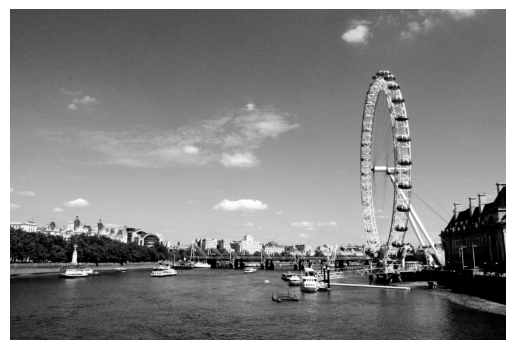

In [ ]:
plt.imshow(image)
plt.axis('off');

**Извлечение «L»**:
нужно изменить  масштаб изображеия, преобразовать в Lab, чтобы извлечь компонент «L» и отцентрировать его

In [ ]:
scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_RGB2LAB)
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

In [ ]:
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

Прогнозирование «а» и «б»:

In [ ]:
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

Создание цветного лабораторного фото **(L + a + b)**:

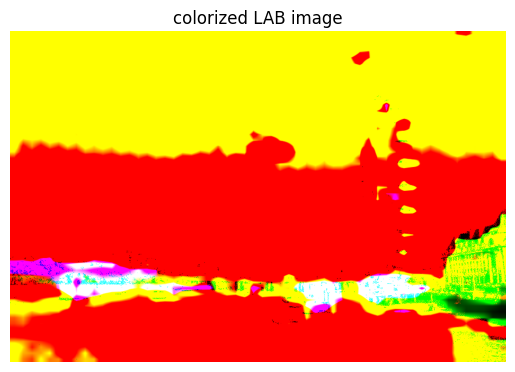

In [ ]:
plt.imshow(colorized)
plt.axis('off');
plt.title('colorized LAB image');

Изображение** Lab** не может  многое рассказать, поэтому нужно преобразовать его в RGB и посмотреть результат:

Преобразование в **RGB**

In [ ]:
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
colorized = np.clip(colorized, 0, 1)

In [ ]:
colorized = (255 * colorized).astype("uint8")

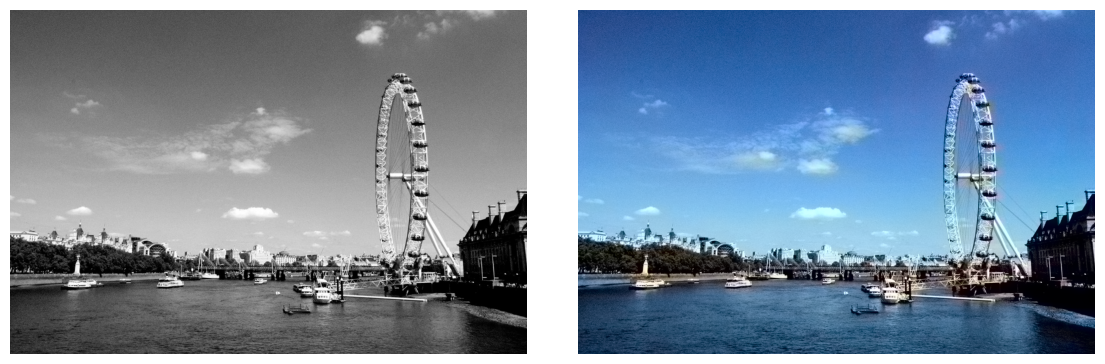

In [ ]:
plt.figure(1, figsize=(14,6))
plt.subplots_adjust(wspace=0.1)
plt.subplot(121)
plt.axis('off');
plt.imshow(image);

plt.subplot(122)
plt.axis('off');
plt.imshow(colorized);